In [1]:
#Time series modelling, the basics
#Simple modelling steps:
#1. Do differencing with ideal lag (based on autocorrelation),
#2. If the result looks stationary (no time-dependent pattern), apply a time series model
#3. If does not look stationary? try differencing again.

########### IT NEEDS TO BE STATIONARY, we need to remove the seasonal components etc!!!

#Autoregression model (AR)

#This is just a linear regression
#Intuition: values at previous time points are informative when predicting the next value.
#For example: sales in the past p days might be useful when predicting sales tomorrow.
#This is exactly what an AR(p) model will fit!


import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.api import tsa ################ tsa - TIME SERIES ANALYSIS !!!!!!!!!!!
from dateutil.parser import parse

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

def parse_quarter(string):
    """
    Converts a string from the format YYYYQN in datetime object at the end of quarter N.
    """
    
    # Note: you could also just retrieve the first four elements of the string
    # and the last one... Regex is fun but often not necessary
    year, qn = re.search(r'^(20[0-9][0-9])(Q[1-4])$', string).group(1, 2)
    
    # year and qn will be strings, pd.datetime expects integers.
    year = int(year)
    
    date = None
    
    if qn=='Q1':
        date = pd.datetime(year, 3, 31)
    elif qn=='Q2':
        date = pd.datetime(year, 6, 30)
    elif qn=='Q3':
        date = pd.datetime(year, 9, 20)
    else:
        date = pd.datetime(year, 12, 31)
        
    return date


alcohol_consumption = pd.read_csv('NZAlcoholConsumption.csv', 
                                  parse_dates=['DATE'], 
                                  date_parser=parse_quarter,
                                  index_col='DATE')
alcohol_consumption.sort_index(inplace=True)

In [4]:
wine.diff(4) #### the first 4 entries has a NAN !!!

DATE
2000-03-31      NaN
2000-06-30      NaN
2000-09-20      NaN
2000-12-31      NaN
2001-03-31   -0.199
2001-06-30   -0.054
2001-09-20    0.190
2001-12-31   -0.069
2002-03-31    0.369
2002-06-30    0.057
2002-09-20    0.231
2002-12-31    0.163
2003-03-31    0.035
2003-06-30    0.115
2003-09-20   -0.124
2003-12-31    0.030
2004-03-31    0.156
2004-06-30    0.124
2004-09-20    0.177
2004-12-31    0.042
2005-03-31    0.130
2005-06-30    0.171
2005-09-20    0.161
2005-12-31    0.125
2006-03-31    0.164
2006-06-30   -0.029
2006-09-20    0.127
2006-12-31    0.231
2007-03-31    0.149
2007-06-30    0.200
2007-09-20   -0.082
2007-12-31   -0.443
2008-03-31   -0.283
2008-06-30   -0.169
2008-09-20   -0.140
2008-12-31    0.809
2009-03-31    0.150
2009-06-30    0.199
2009-09-20    0.011
2009-12-31   -0.249
2010-03-31    0.342
2010-06-30   -0.030
2010-09-20    0.109
2010-12-31    0.387
2011-03-31   -0.253
2011-06-30    0.039
2011-09-20    0.200
2011-12-31   -0.513
2012-03-31    0.187
2012-06-30    0

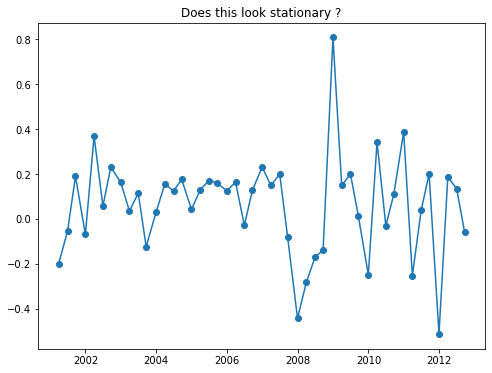

In [6]:
wine = alcohol_consumption.TotalWine
wine_diff = wine.diff(4).dropna()

plt.figure(figsize=(8, 6))
plt.plot(wine_diff, "-o")
plt.title("Does this look stationary ?");

In [8]:
# Autoregression model
# In an autoregression model, values are modelled as a linear combination of the 𝑝 past values. 
# An autoregressive model of order 𝑝, that is usually indicated as 𝐴𝑅(𝑝)
# The library statsmodels contains a tsa module which implements the autoregressive model.
# Task:
# Define an AR model using tsa.AR 
# select the order using the select_order method. You will need to specify a maximum p to consider and 
# a criterion for deciding which model is "best" 
# AIC and BIC are common parameters which encourage "good fit" while penalising having too many parameters (complex model). 

time_series = wine_diff

ar = tsa.AR(time_series)
optlag = ar.select_order(10, ic="aic") #### ic == information criteria, it can be "aic" or "bic"
print('Optimal p =', optlag)

C:\Anaconda3\envs\ads4ldn\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Optimal p = 5


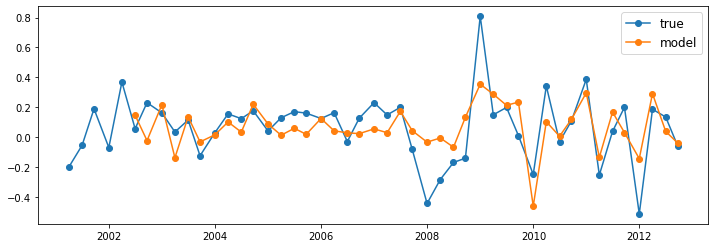

In [9]:
ar_result = ar.fit(maxlag=optlag)
prediction = ar_result.predict(start=optlag) #### optlag = autoregression parameter, found previously!!!

plt.figure(figsize=(12, 4))
plt.plot(time_series, '-o', label='true')
plt.plot(prediction, '-o', label='model')
plt.legend(fontsize=12);

In [10]:
print('MAE = {0:.3f}'.format(mean_absolute_error(time_series[optlag:], prediction))) ### to be used as a baseline!!

MAE = 0.131


In [15]:
# Autoregression with Sklearn
# Autoregression can also be implemented using sklearn. However, it doesn't provide direct support to handle time series, 
# which means that you have to reorganise the data before estimating the model:

def organize_data(to_forecast, window, horizon=1):
    """
     Input:
      to_forecast, univariate time series organised as numpy array
      window, number of observations to use in a forecast window
      horizon, horizon of the forecast
     Output:
      X, a matrix where each row contains a forecast window
      y, the target values for each row of X
    """
    shape = to_forecast.shape[:-1] + (to_forecast.shape[-1] - window + 1, window)
    strides = to_forecast.strides + (to_forecast.strides[-1],)
    X = np.lib.stride_tricks.as_strided(to_forecast,
                                        shape=shape,
                                        strides=strides)
    y = np.array([X[i+horizon][-1] for i in range(len(X)-horizon)])
    return X[:-horizon], y

X, y = organize_data(time_series, optlag)

C:\Anaconda3\envs\ads4ldn\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: Series.strides is deprecated and will be removed in a future version
  app.launch_new_instance()


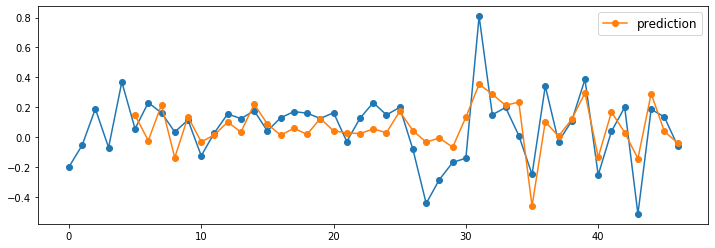

In [16]:
### We can now fit an autoregressive model which simply corresponds to a LinearRegression now:

lr = LinearRegression()
lr.fit(X, y)
prediction = lr.predict(X)

plt.figure(figsize=(12, 4))
plt.plot(time_series.values, '-o',)
plt.plot(np.arange(optlag, len(time_series)), prediction, '-o', label='prediction')
plt.legend(fontsize=12);


C:\Anaconda3\envs\ads4ldn\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


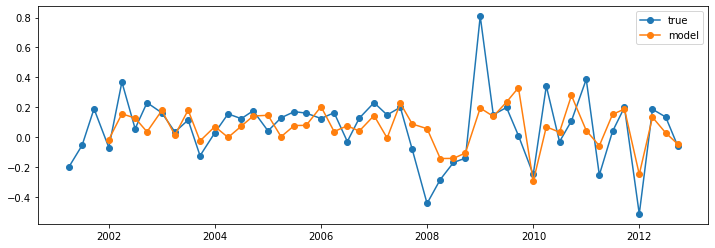

In [17]:
#ARMA model
# with an autoregressive part that you will recognise and a part that corresponds to a moving average
#ARMA models are also implemented in statsmodels and their implementation is consistent with the one of AR models. 
#Create an ARMA model with tsa.ARMA, specify 
#Since the result will look almost identical to just using AR, you will want to show the MAE as well. 

arma = tsa.ARMA(time_series, order=(3, 3))
arma_result = arma.fit()
prediction = arma_result.predict(start=3)

plt.figure(figsize=(12, 4))
plt.plot(time_series, '-o', label='true')
plt.plot(prediction, '-o', label='model')
plt.legend();

In [19]:
print('MAE = {0:.3f}'.format(mean_absolute_error(time_series[3:], prediction)))

MAE = 0.127


In [21]:
#Testing for forecasting models
#Testing a standard prediction model can be done using cross-validation. 
#Usually we don't need to worry about ordering over observations so we can just go ahead and divide the data into K folds. 
#However, we time-series data we need to take care to account for the chronological ordering of observations!
#We can account for the chronological ordering by making sure that we only use past observations when making predictions 
#(this also makes it realistic in a production setting!).

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from statsmodels.api import tsa
from dateutil.parser import parse

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

def parse_quarter(string):
    """
    Converts a string from the format YYYYQN in datetime object at the end of quarter N.
    """
    
    # Note: you could also just retrieve the first four elements of the string
    # and the last one... Regex is fun but often not necessary
    year, qn = re.search(r'^(20[0-9][0-9])(Q[1-4])$', string).group(1, 2)
    
    # year and qn will be strings, pd.datetime expects integers.
    year = int(year)
    
    date = None
    
    if qn=='Q1':
        date = pd.datetime(year, 3, 31)
    elif qn=='Q2':
        date = pd.datetime(year, 6, 30)
    elif qn=='Q3':
        date = pd.datetime(year, 9, 20)
    else:
        date = pd.datetime(year, 12, 31)
        
    return date


alcohol_consumption = pd.read_csv('NZAlcoholConsumption.csv', 
                                  parse_dates=['DATE'], 
                                  date_parser=parse_quarter,
                                  index_col='DATE')
alcohol_consumption.sort_index(inplace=True)

In [22]:
wine = alcohol_consumption.TotalWine
wine

DATE
2000-03-31    1.486
2000-06-30    1.915
2000-09-20    1.844
2000-12-31    2.808
2001-03-31    1.287
2001-06-30    1.861
2001-09-20    2.034
2001-12-31    2.739
2002-03-31    1.656
2002-06-30    1.918
2002-09-20    2.265
2002-12-31    2.902
2003-03-31    1.691
2003-06-30    2.033
2003-09-20    2.141
2003-12-31    2.932
2004-03-31    1.847
2004-06-30    2.157
2004-09-20    2.318
2004-12-31    2.974
2005-03-31    1.977
2005-06-30    2.328
2005-09-20    2.479
2005-12-31    3.099
2006-03-31    2.141
2006-06-30    2.299
2006-09-20    2.606
2006-12-31    3.330
2007-03-31    2.290
2007-06-30    2.499
2007-09-20    2.524
2007-12-31    2.887
2008-03-31    2.007
2008-06-30    2.330
2008-09-20    2.384
2008-12-31    3.696
2009-03-31    2.157
2009-06-30    2.529
2009-09-20    2.395
2009-12-31    3.447
2010-03-31    2.499
2010-06-30    2.499
2010-09-20    2.504
2010-12-31    3.834
2011-03-31    2.246
2011-06-30    2.538
2011-09-20    2.704
2011-12-31    3.321
2012-03-31    2.433
2012-06-30    2

In [23]:
wine_diff = wine.diff(4).dropna()
wine_diff

DATE
2001-03-31   -0.199
2001-06-30   -0.054
2001-09-20    0.190
2001-12-31   -0.069
2002-03-31    0.369
2002-06-30    0.057
2002-09-20    0.231
2002-12-31    0.163
2003-03-31    0.035
2003-06-30    0.115
2003-09-20   -0.124
2003-12-31    0.030
2004-03-31    0.156
2004-06-30    0.124
2004-09-20    0.177
2004-12-31    0.042
2005-03-31    0.130
2005-06-30    0.171
2005-09-20    0.161
2005-12-31    0.125
2006-03-31    0.164
2006-06-30   -0.029
2006-09-20    0.127
2006-12-31    0.231
2007-03-31    0.149
2007-06-30    0.200
2007-09-20   -0.082
2007-12-31   -0.443
2008-03-31   -0.283
2008-06-30   -0.169
2008-09-20   -0.140
2008-12-31    0.809
2009-03-31    0.150
2009-06-30    0.199
2009-09-20    0.011
2009-12-31   -0.249
2010-03-31    0.342
2010-06-30   -0.030
2010-09-20    0.109
2010-12-31    0.387
2011-03-31   -0.253
2011-06-30    0.039
2011-09-20    0.200
2011-12-31   -0.513
2012-03-31    0.187
2012-06-30    0.135
2012-09-20   -0.057
Name: TotalWine, dtype: float64

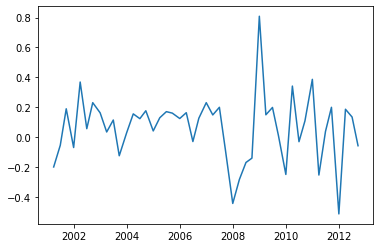

In [24]:
time_series = wine_diff
plt.plot( time_series )

C:\Anaconda3\envs\ads4ldn\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Out of sample MAE = 0.273


C:\Anaconda3\envs\ads4ldn\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


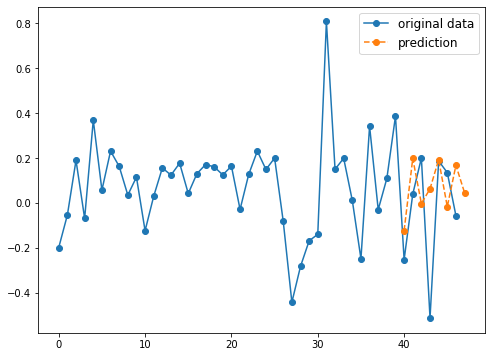

In [25]:
#Forecasting¶
#Separate the time series into a training set and a test set formed of the last 8 points. 
#Fit an AR model on the training data and try to find the optimal lag using the BIC criterion
#fit the model, predict and show the prediction on the original time series. FINALLY compute the MAE

# divide data into training and testing:
train = time_series[:-8]
test = time_series[-8:]

# fit our AR model using the tsa module! 
ar = tsa.AR(train)

# choose the optimal lag using BIC (this is a model selection criterion, dont worry if you dont know what it is :))

optlag = ar.select_order(10, ic='bic', method='mle') ############# test from 1 to 10 lags, select the OPTLAG!!!


# now we fit our model with the chosen optimal lag:
arfit = ar.fit(maxlag=optlag)

# we make predictions on unseen data:
prediction = arfit.predict(end=len(time_series))[-len(test):] ########## just taking the final 8 entries of the prediction!!!!

# produce some figures:
plt.figure(figsize=(8, 6))
plt.plot(time_series.values, '-o', label="original data")
plt.plot(prediction, '--o', label='prediction')

plt.legend(fontsize=12)

print('Out of sample MAE = {0:.3f}'.format(mean_absolute_error(test, prediction))) ## MAE worst than before as we are 
                                                                                   ## now predicting in the TEST data!!!

In [26]:
prediction

40   -0.123386
41    0.198116
42   -0.002744
43    0.063025
44    0.192453
45   -0.016576
46    0.167591
47    0.045614
dtype: float64

In [27]:
test

DATE
2010-12-31    0.387
2011-03-31   -0.253
2011-06-30    0.039
2011-09-20    0.200
2011-12-31   -0.513
2012-03-31    0.187
2012-06-30    0.135
2012-09-20   -0.057
Name: TotalWine, dtype: float64

In [28]:
#Cross-Validation for Time Series Forecasting (demo)
#Recall that it is important not to use future observations during a forecast! 
#Below we will define a function to take a certain number of observations (ordered chronologically) as training data and 
#use the remainder as testing data. We will also visualize their predictions :) 

def Forecasting_crossValidation( time_series, training_size ):
    """
    Given a pd.Series we train a autoregressive model. 
    The number of training observation is specified by the variable training_size
    """
    train = time_series[:training_size]
    test = time_series[training_size:]
    ar = tsa.AR(train)
    ar_result = ar.fit(maxlag=4)
    prediction = ar_result.predict(end=len(time_series))[-len(test):]
    
    # compute the MAE:
    mae = mean_absolute_error(time_series.values[training_size:], prediction)
    print('Mean absolute error: ' + str(mae))
    
    # plot results as well:
    plt.plot(time_series.values, '-o', label='true')
    plt.plot(range(training_size, len(time_series)), prediction, 
         '-o', label='out of sample prediction')
    plt.legend();
    
    return prediction

Mean absolute error: 0.31891918841013883


C:\Anaconda3\envs\ads4ldn\lib\site-packages\statsmodels\tsa\base\tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
C:\Anaconda3\envs\ads4ldn\lib\site-packages\statsmodels\tsa\base\tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


44    0.309175
45    0.089251
46    0.030123
47    0.193876
dtype: float64

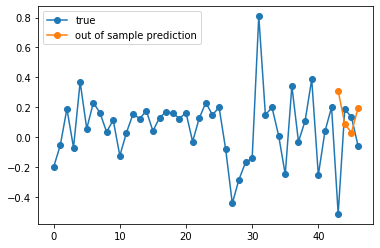

In [29]:
Forecasting_crossValidation( time_series, 43)

########## rule of thumb -- we should never really conpare performance on training data, it should always be on test data!!
